In [ ]:
# 1. Instalar Java y Spark (Necesario porque Colab no trae Java 8 por defecto a veces)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark duckdb plotly

# 2. Configurar variables de entorno para que Python encuentre a Java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# 3. Montar Google Drive (Para guardar tus Notebooks y los Parquet finales)
from google.colab import drive
drive.mount('/content/drive')

# Crear carpeta para el proyecto si no existe
!mkdir -p "/content/drive/MyDrive/ProyectoBigData/data/silver"

In [ ]:
# --- BLOQUE 1: INSTALACIÓN Y CONFIGURACIÓN ---
import os
from google.colab import files
from google.colab import drive

# 1. Montamos Google Drive (Para guardar los resultados finales y que no se borren)
print("📂 Montando Google Drive...")
drive.mount('/content/drive')

# Creamos la carpeta para el proyecto en tu Drive si no existe
!mkdir -p "/content/drive/MyDrive/ProyectoBigData/data/silver"

# 2. Instalamos Java y Spark (Necesario para que funcione PySpark en Colab)
print("☕ Instalando Java y Spark (esto toma unos segundos)...")
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark duckdb plotly -q

# Configuramos donde está Java para que Python lo encuentre
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# 3. Subir la credencial de Kaggle
print("🔑 Por favor, sube el archivo 'kaggle.json' cuando aparezca el botón abajo:")
uploaded = files.upload() # AQUÍ SE DETENDRÁ PARA QUE SUBAS EL ARCHIVO

# Mover la credencial a su carpeta oculta y darle permisos de seguridad
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✅ Credenciales configuradas.")

# 4. Descargar el dataset directamente de Kaggle
print("⬇️ Descargando dataset (esto vuela porque es servidor a servidor)...")
# Usamos la opción --force para que no falle si ya existe
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store --force

# 5. Descomprimir
print("📦 Descomprimiendo archivos...")
!unzip -q ecommerce-behavior-data-from-multi-category-store.zip -d /content/data_raw
print("🎉 ¡TODO LISTO! Datos disponibles en /content/data_raw/")

In [ ]:
# 1. Actualizamos los repositorios de Linux (para arreglar el error 404)
print("🔧 Actualizando sistema...")
!apt-get update > /dev/null

# 2. Instalamos Java de nuevo
print("☕ Instalando Java (Intento 2)...")
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 3. Verificamos que haya quedado bien
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
print("✅ Verificando versión de Java:")
!java -version

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, to_date

# --- CONFIGURACIÓN DE SPARK ---
# Le damos harta memoria RAM para que aguante el peso
spark = SparkSession.builder \
    .appName("ProyectoBigData_OpB") \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

print("Spark iniciado correctamente.")

# --- 1. LECTURA ---
# Leemos todos los CSV que descomprimiste en la carpeta data_raw
print("Leyendo CSVs (esto puede tomar 1 o 2 minutos)...")
df_raw = spark.read.option("header", "true").csv("/content/data_raw/*.csv")

# --- 2. TRANSFORMACIÓN ---
print("Limpiando y ajustando tipos de datos...")
# Convertimos strings a fechas y números reales
df_silver = df_raw.withColumn("event_time", to_timestamp("event_time")) \
                  .withColumn("event_date", to_date("event_time")) \
                  .withColumn("price", col("price").cast("double")) \
                  .withColumn("user_id", col("user_id").cast("long"))

# --- 3. GUARDADO (ETL) ---
ruta_guardado = "/content/drive/MyDrive/ProyectoBigData/data/silver/ecommerce_events"

print(f"Guardando en Google Drive: {ruta_guardado}")
print("ESTO TARDARÁ ENTRE 5 Y 10 MINUTOS. NO CIERRES LA PESTAÑA.")

# Escribimos en formato Parquet, particionado por fecha, ideal para DuckDB
df_silver.write \
    .partitionBy("event_date") \
    .mode("overwrite") \
    .parquet(ruta_guardado)

print("🎉 ¡LISTO! Ya tienes tu Data Lake creado en Google Drive.")
spark.stop()

## Reinicio en caso de actualización de paquetes

In [1]:
# 1. Volver a conectar Drive después de reiniciar entorno
from google.colab import drive
drive.mount('/content/drive')

# 2. Importar librerías frescas
import duckdb
import pandas as pd
import plotly.express as px
import time

print("✅ Entorno reiniciado y librerías cargadas correctamente.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Entorno reiniciado y librerías cargadas correctamente.


# Dashboard

In [2]:
pip install plotly

In [3]:
pip install -U kaleido

In [4]:
# Desinstalamos por si acaso hay basura
!pip uninstall -y kaleido

# Instalamos la versión específica que se lleva bien con Colab
!pip install kaleido==0.2.1

print("✅ Instalación completada.")

Found existing installation: kaleido 1.2.0
Uninstalling kaleido-1.2.0:
  Successfully uninstalled kaleido-1.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.3 MB/s eta 0:00:00
✅ Instalación completada.


Conectando DuckDB a: /content/drive/MyDrive/ProyectoBigData/data/silver/ecommerce_events/**/*.parquet
Total de eventos cargados para análisis: 109,950,743

Generando KPI 1: Tendencia diaria...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

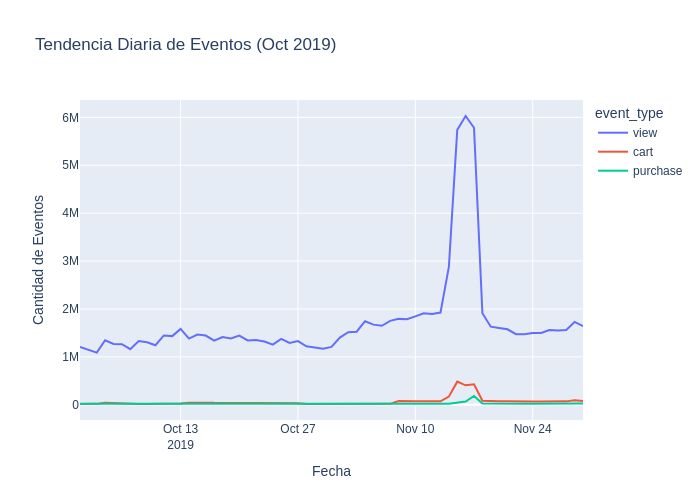


Generando KPI 2: Funnel de Conversión...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

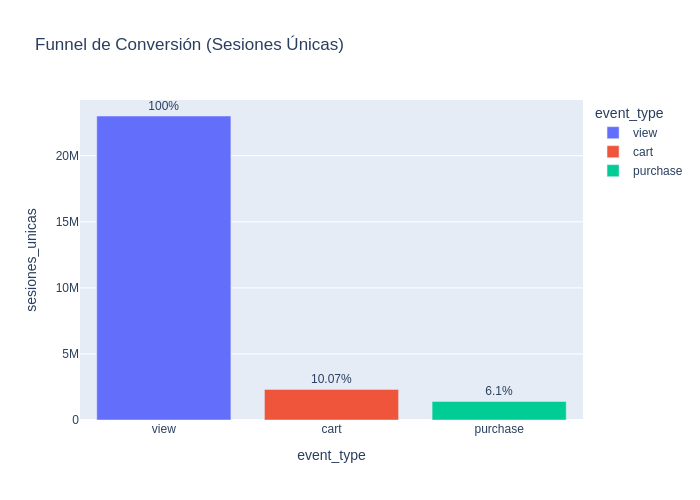


Generando KPI 3: Top Marcas...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

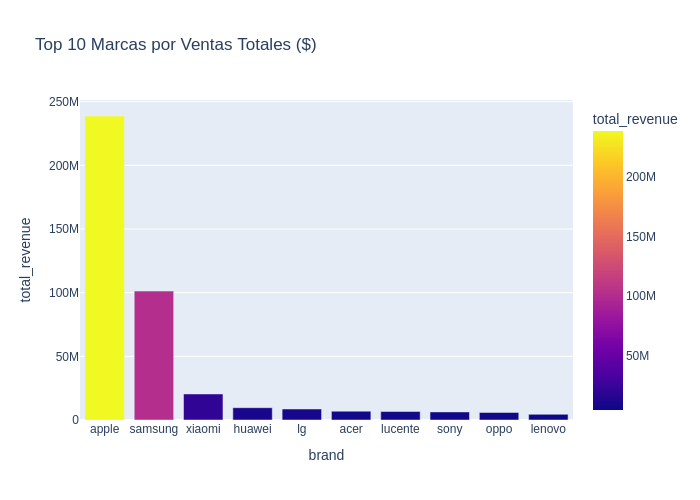

In [5]:
# --- BLOQUE 3: ANÁLISIS Y DASHBOARD ---
import duckdb
import pandas as pd
import plotly.express as px
import time
import kaleido
import plotly.io as pio
pio.renderers.default = "colab"

# 1. Configurar la conexión a los datos
# Apuntamos a la carpeta en TU Drive donde Spark guardó los parquets
ruta_datos = "/content/drive/MyDrive/ProyectoBigData/data/silver/ecommerce_events/**/*.parquet"

print(f"Conectando DuckDB a: {ruta_datos}")

# Hacemos una consulta de prueba para ver que todo cargue bien
count = duckdb.sql(f"SELECT COUNT(*) FROM read_parquet('{ruta_datos}')").fetchone()[0]
print(f"Total de eventos cargados para análisis: {count:,}")


# --- KPI 1: Tendencia Temporal (Eventos por día) ---
print("\nGenerando KPI 1: Tendencia diaria...")
query_trend = f"""
    SELECT
        event_date,
        event_type,
        COUNT(*) as total_events
    FROM read_parquet('{ruta_datos}')
    GROUP BY event_date, event_type
    ORDER BY event_date
"""
# DuckDB ejecuta esto en segundos y nos da un dataframe pequeño para graficar
df_trend = duckdb.sql(query_trend).df()

# Gráfico interactivo
fig_trend = px.line(df_trend, x='event_date', y='total_events', color='event_type',
                    title="Tendencia Diaria de Eventos (Oct 2019)",
                    labels={'total_events': 'Cantidad de Eventos', 'event_date': 'Fecha'})
fig_trend.show(renderer="png")


# --- KPI 2: Funnel de Conversión (Vista -> Carrito -> Compra) ---
print("\nGenerando KPI 2: Funnel de Conversión...")
# Contamos sesiones únicas que hicieron cada acción
query_funnel = f"""
    SELECT
        event_type,
        COUNT(DISTINCT user_session) as sesiones_unicas
    FROM read_parquet('{ruta_datos}')
    WHERE event_type IN ('view', 'cart', 'purchase')
    GROUP BY event_type
    ORDER BY sesiones_unicas DESC
"""
df_funnel = duckdb.sql(query_funnel).df()

# Calculamos el porcentaje de conversión
total_vistas = df_funnel[df_funnel['event_type'] == 'view']['sesiones_unicas'].values[0]
df_funnel['tasa_conversion'] = (df_funnel['sesiones_unicas'] / total_vistas * 100).round(2)

fig_funnel = px.bar(df_funnel, x='event_type', y='sesiones_unicas',
                    text='tasa_conversion',
                    title="Funnel de Conversión (Sesiones Únicas)",
                    color='event_type')
fig_funnel.update_traces(texttemplate='%{text}%', textposition='outside')
fig_funnel.show(renderer="png")


# --- KPI 3: Top 10 Marcas por Ingresos ---
print("\nGenerando KPI 3: Top Marcas...")
query_brands = f"""
    SELECT
        brand,
        SUM(price) as total_revenue
    FROM read_parquet('{ruta_datos}')
    WHERE event_type = 'purchase' AND brand IS NOT NULL
    GROUP BY brand
    ORDER BY total_revenue DESC
    LIMIT 10
"""
df_brands = duckdb.sql(query_brands).df()

fig_brands = px.bar(df_brands, x='brand', y='total_revenue',
                    title="Top 10 Marcas por Ventas Totales ($)",
                    color='total_revenue')
fig_brands.show(renderer="png")

# Comparación con Pandas

In [4]:
# --- BLOQUE 4: COMPARACIÓN DE RENDIMIENTO (Pandas vs DuckDB) ---
print("\nIniciando prueba de rendimiento...")

# CASO 1: PANDAS (Lento / Memoria limitada)
# Pandas no puede leer todo el dataset sin explotar la RAM de Colab.
# Leeremos SOLO UN DÍA para simular la limitación.
start = time.time()
# Buscamos un archivo parquet específico de un día
archivo_ejemplo = "/content/drive/MyDrive/ProyectoBigData/data/silver/ecommerce_events/event_date=2019-10-01/*.parquet"
try:
    # Glob para encontrar el archivo exacto
    import glob
    file_path = glob.glob(archivo_ejemplo)[0]

    df_pandas = pd.read_parquet(file_path)
    res_pandas = df_pandas.groupby('brand')['price'].sum()
    time_pandas = time.time() - start
    print(f"Pandas (procesando solo 1 día): {time_pandas:.4f} segundos")
except:
    print("No se pudo ejecutar la prueba de Pandas (quizás no se encontró la ruta exacta).")

# CASO 2: DUCKDB (Rápido / Big Data)
# DuckDB leerá TODO EL MES (30 veces más datos)
start = time.time()
res_duck = duckdb.sql(f"""
    SELECT brand, SUM(price)
    FROM read_parquet('{ruta_datos}')
    GROUP BY brand
""").fetchall()
time_duck = time.time() - start

print(f"DuckDB (procesando TODO el mes): {time_duck:.4f} segundos")

print("\n--- CONCLUSIÓN ---")
print("DuckDB es capaz de procesar el dataset completo en un tiempo similar o menor")
print("al que Pandas tarda en procesar solo una fracción de los datos,")
print("sin necesidad de cargar todo en la memoria RAM.")


Iniciando prueba de rendimiento...
Pandas (procesando solo 1 día): 2.7462 segundos


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB (procesando TODO el mes): 7.6633 segundos

--- CONCLUSIÓN ---
DuckDB es capaz de procesar el dataset completo en un tiempo similar o menor
al que Pandas tarda en procesar solo una fracción de los datos,
sin necesidad de cargar todo en la memoria RAM.



Generando Comparación de Precios (Boxplot)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

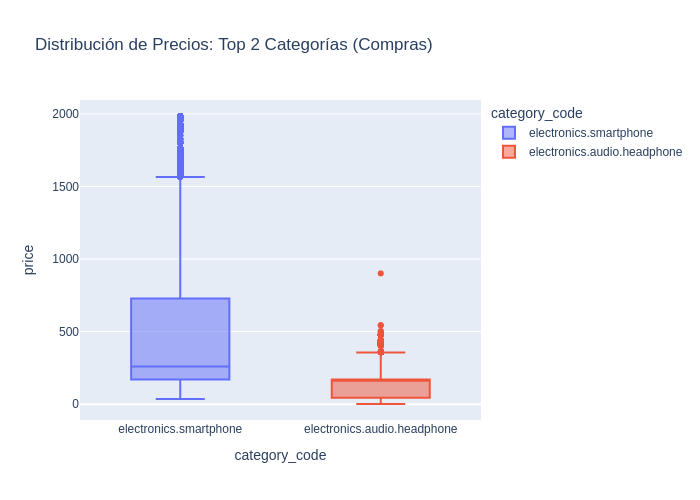


Generando Pregunta Propia 1: Hora pico de ventas...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

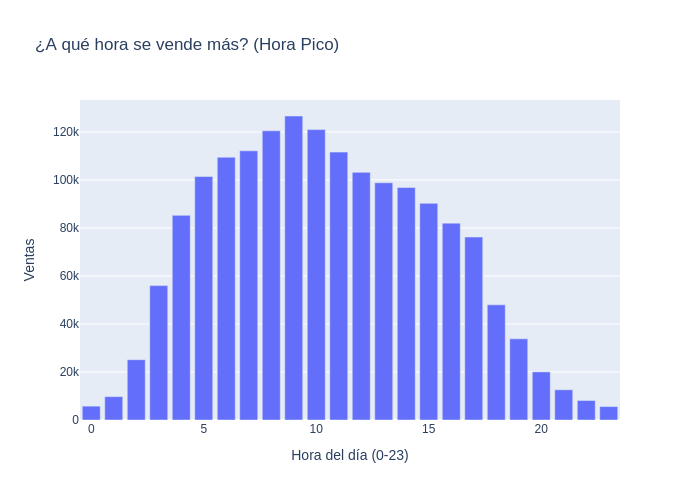


Generando Pregunta Propia 2: Gasto promedio...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


💰 RESPUESTA PROPIA 2: El ticket promedio de compra por usuario es $724.26 USD


In [7]:
# --- BLOQUE FINAL: REQUISITOS FALTANTES ---

# 1. REQUISITO OBLIGATORIO: Distribución de Precios entre Categorías
# Vamos a comparar las 2 categorías más vendidas para ver cómo varían sus precios
print("\nGenerando Comparación de Precios (Boxplot)...")

query_price_dist = f"""
    WITH top_cats AS (
        SELECT category_code
        FROM read_parquet('{ruta_datos}')
        WHERE event_type = 'purchase' AND category_code IS NOT NULL
        GROUP BY category_code
        ORDER BY count(*) DESC
        LIMIT 2
    )
    SELECT category_code, price
    FROM read_parquet('{ruta_datos}')
    WHERE event_type = 'purchase'
      AND category_code IN (SELECT category_code FROM top_cats)
      AND price < 2000 -- Filtramos outliers extremos para que se vea bien el gráfico
"""
df_prices = duckdb.sql(query_price_dist).df()

fig_prices = px.box(df_prices, x='category_code', y='price', color='category_code',
                    title="Distribución de Precios: Top 2 Categorías (Compras)")
fig_prices.show(renderer="png")


# 2. PREGUNTA PROPIA 1: ¿A qué hora compran más los usuarios? (Heatmap de actividad)
print("\nGenerando Pregunta Propia 1: Hora pico de ventas...")
query_hour = f"""
    SELECT
        hour(event_time) as hora_dia,
        COUNT(*) as total_compras
    FROM read_parquet('{ruta_datos}')
    WHERE event_type = 'purchase'
    GROUP BY hora_dia
    ORDER BY hora_dia
"""
df_hour = duckdb.sql(query_hour).df()

fig_hour = px.bar(df_hour, x='hora_dia', y='total_compras',
                  title="¿A qué hora se vende más? (Hora Pico)",
                  labels={'hora_dia': 'Hora del día (0-23)', 'total_compras': 'Ventas'})
fig_hour.show(renderer="png")


# 3. PREGUNTA PROPIA 2: ¿Cuál es el promedio de gasto por usuario?
print("\nGenerando Pregunta Propia 2: Gasto promedio...")
query_ticket = f"""
    SELECT
        AVG(gasto_total) as ticket_promedio
    FROM (
        SELECT user_id, SUM(price) as gasto_total
        FROM read_parquet('{ruta_datos}')
        WHERE event_type = 'purchase'
        GROUP BY user_id
    )
"""
ticket = duckdb.sql(query_ticket).fetchone()[0]
print(f"\n💰 RESPUESTA PROPIA 2: El ticket promedio de compra por usuario es ${ticket:.2f} USD")